# Extraction of SWR from CA1 recordings

Restarting from LFPwake0 and LFPwakeremoved.

LFPwakeremoved will be used to determined signal variance for threshold adjustement. 

LFPwake0 will be used for time determination. 

## Load LFP and packages

In [1]:
from scipy import signal
from scipy.signal import find_peaks
from scipy.signal import chirp, find_peaks, peak_widths
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
from pathlib import Path
import os
from ipyfilechooser import FileChooser
from IPython.display import display
import ipywidgets as widgets


%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer, EventList, InMemoryEventSource, TimeFreqViewer
from ephyviewer import AnalogSignalSourceWithScatter,InMemoryAnalogSignalSource
import ephyviewer

from mbTools import mbTools

In [2]:
dpath = ""
try:
    %store -r dpath
except:
    print("data path not in strore")
    dpath = os.path.expanduser("~")

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>OpenEphys Folder</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\CGP\GreenDotsOK\…

In [3]:
suffix='_AH'#'_AB'
ID=''#'_AB'
sep = -5 # -3 if Baseline #-4 if CGP
animalIDPos = -4 # -3 if Baseline #-4 if CGP
dirPathComponents = os.path.normpath(dpath).split(os.sep)
mapPath = os.path.sep.join(dirPathComponents[:sep-1]) #"//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023" 
folder_base = os.path.sep.join(dirPathComponents[sep-1:])
mice = dirPathComponents[animalIDPos]
#os.chdir(mapPath)
print(mapPath)
print(folder_base)
print(mice)

\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023
Gaelle\CGP\GreenDotsOK\CGP\session2\OpenEphys
GreenDotsOK


In [4]:
#filenameOutput2 = os.path.join(mapPath, folder_base,f'Spindlesproperties_{structure}{suffix}.pkl')
#filenameOutput3 = os.path.join(mapPath, folder_base,f'Spindlesproperties_{structure}{suffix}.csv')
filenameOutput3 = os.path.join(mapPath, folder_base,f'SWRproperties{ID}.csv')

ResetAnalysis=True #False or True

if os.path.isfile(filenameOutput3):
    if not ResetAnalysis:         
        print(f'previous file imported and used : {filenameOutput3}')
        All_SWR = pd.read_excel(filenameOutput3)
        print(All_SWR)
    else:
        print(f'/!\ pre-existing file will be deleted and replaced : {filenameOutput3}')
else:
    ResetAnalysis=True
    print(f"no previous analysis found, creation of : {filenameOutput3}")

/!\ pre-existing file will be deleted and replaced : \\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\CGP\GreenDotsOK\CGP\session2\OpenEphys\SWRproperties.csv


In [5]:
if ResetAnalysis: 
    filename3 = os.path.join(dpath,f'LFPwakeremoved{suffix}.npy')
    filename2 = os.path.join(dpath,'RawDataChannelExtractedDS.npy')
    EMGbooleaninput = os.path.join(dpath,f'EMGframeBoolean{suffix}.pkl')


    EMGboolean = pd.read_pickle(EMGbooleaninput)
    LFPwakeremoved = np.load(filename3, mmap_mode= 'r')
    All = np.load(filename2, mmap_mode= 'r')

    try:
        Channels = os.path.join(mapPath,f'LFPChannels_perMice.xlsx')
        allchannels = pd.read_excel(Channels)
        CA1ch1=int(allchannels[mice][2].split(',')[0])
        CA1ch2=int(allchannels[mice][2].split(',')[1])
        EMGch=int(allchannels[mice][3])
        EMG  =  All[:, EMGch]
    except FileNotFoundError as e:
        print(mbTools.color.BOLD + mbTools.color.YELLOW)
        print(f"File {os.path.join(mapPath,f'LFPChannels_perMice.xlsx')} not found!")
        print("probably you are not Aurélie... or the path to access it is wrong.")
        print("In the first case, make sure the mapping is rightfully setup in the curent cell")
        print("In the second case, you can play with the 'sep' variable of cell 3, or directly change the path")
        print(mbTools.color.END)
        PFCch1=19
        PFCch2=20
        CA1ch1=21
        CA1ch2=22

    CA1  =  All[:, CA1ch1]-All[:, CA1ch2] 
    CA1wakeremoved = LFPwakeremoved[:,CA1ch1]-LFPwakeremoved[:,CA1ch2] 

# Band pass filter
        SWR: 120-200 Hz

In [6]:
if ResetAnalysis: 

    # Filtre parameter:
    f_lowcut = 120.
    f_hicut = 200.
    fs = 1000
    nyq = 0.5 * fs
    N = 6                 # Filtre order
    Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

    # Filtering:
    b, a = signal.butter(N, Wn, 'band')
    filt_CA1 = signal.filtfilt(b, a, CA1)
    filt_CA1wakeremoved = signal.filtfilt(b, a, CA1wakeremoved)

    # Plot
    times = np.arange(0, CA1.size/fs, 1./fs)
    #timesmin = np.arange(0, CA1.size/fs/60, 1./fs/60)
    #fig, ax = plt.subplots()
    #ax.plot(timesmin, filt_CA1)

## Continuous Wavelet Transform and projection calculation

First on signal with no wake time to determine sd of signal

In [7]:
if ResetAnalysis: 

    # Parameter and computation of CWT
    w = 10.
    freq = np.linspace(120, 200, 80)
    widths = w*fs / (2*freq*np.pi)
    CA1NWcwt = signal.cwt(filt_CA1wakeremoved, signal.morlet2, widths, w=w)

    # Projection calculation
    absCA1NWcwt = np.absolute(CA1NWcwt)
    proj_CA1NWcwt = np.sum(absCA1NWcwt, axis = 0)/80
    sdproj_CA1cwt = np.std(proj_CA1NWcwt)

Second on the signal for which wake times have been zeroed

In [8]:
if ResetAnalysis: 
    # Conservative boolean filtering of CA1 filtered signal
    BooleanCons = EMGboolean['BooleanConservative']
    fCA1wake0C = filt_CA1.copy()
    fCA1wake0C[BooleanCons] = 0
    CA1wake0C = CA1.copy()
    CA1wake0C[BooleanCons] = 0
    # Liberal boolean filtering of CA1 filtered signal
    BooleanLib = EMGboolean['BooleanLiberal']
    fCA1wake0L = filt_CA1.copy()
    fCA1wake0L[BooleanLib] = 0
    CA1wake0L = CA1.copy()
    CA1wake0L[BooleanLib] = 0

    # Computation of CWT
    CA1cwtWake0cons = signal.cwt(fCA1wake0C, signal.morlet2, widths, w=w)
    CA1cwtWake0lib = signal.cwt(fCA1wake0L, signal.morlet2, widths, w=w)

    # Projection calculation
    absCA1W0Ccwt = np.absolute(CA1cwtWake0cons)
    proj_CA1W0Ccwt = np.sum(absCA1W0Ccwt, axis = 0)/80
    absCA1W0Lcwt = np.absolute(CA1cwtWake0lib)
    proj_CA1W0Lcwt = np.sum(absCA1W0Lcwt, axis = 0)/80


## Define Threshlod

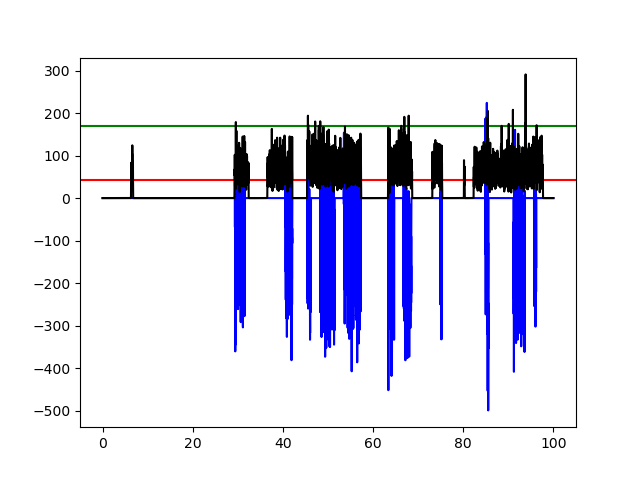

In [9]:
if ResetAnalysis: 
    # Defining subset
    start = 00000
    end = 100000

    times = np.arange(0, CA1.size/fs, 1./fs)
    tt = times[start:end]
    Cortext = CA1wake0C[start:end]/10
    #Cortexcwtt = PFCNWcwt[:, start:end]
    proj_Cortexcwtt = proj_CA1W0Lcwt[start:end]

    plt.close('all')
    plt.axhline(sdproj_CA1cwt, color='r') # horizontal
    plt.axhline(sdproj_CA1cwt*4, color='g') # horizontal
    plt.plot(tt, Cortext,'b')
    plt.plot(tt, proj_Cortexcwtt,'k')
    plt.show()

In [20]:
if ResetAnalysis: 
    sd_thresh = sdproj_CA1cwt*6.5

## Extracting SWRs and determining main properties 

First extraction of SWR peaks, initiation, end and width

In [21]:
if ResetAnalysis: 

    peaks, properties = find_peaks(proj_CA1W0Lcwt, prominence=1, width=20, height=sd_thresh)
    properties["prominences"], properties["widths"]

    # SWR boundaries taken at 70% from peak of intensity. This means that the SWRs with small amplitude will be longer than the big ones.
    results_width = peak_widths(proj_CA1W0Lcwt, peaks, rel_height=0.7)

    # Organise results in numpy array
    peaks2 = peaks.reshape(len(peaks),1)
    npresults_width = np.array(results_width).reshape(4,-1)
    SWR_prop = np.append(peaks2, results_width).reshape(5,len(peaks2)).round()
    print(peaks.shape)

(315,)


### Store the results in All_SWR_prop pd dataframe and save as pkl/csv for post processing.

End of Notebook. 

In [22]:
if ResetAnalysis: 

    projMaxP_cwtmg = np.max(CA1cwtWake0lib, axis = 0)
    projMaxF_cwtmg = np.argmax(CA1cwtWake0lib, axis = 0) + 120
    projMaxP_cwtmg.shape

    nb_SWR = len(peaks)
    data = np.zeros((nb_SWR,4))

    for tt in np.arange(nb_SWR):
        SWR_start = int(SWR_prop[3,tt])
        SWR_stop = int(SWR_prop[4,tt])
        SWR_MaxP = projMaxP_cwtmg[SWR_start:SWR_stop]
        SWR_MaxF = projMaxF_cwtmg[SWR_start:SWR_stop]
        data[tt, 0] = max(SWR_MaxF).round()
        data[tt, 1] = max(SWR_MaxP).round()
        data[tt, 2] = round(sum(SWR_MaxF)/len(SWR_MaxF))
        data[tt, 3] = round(sum(SWR_MaxP)/len(SWR_MaxP))

    param_SWR = pd.DataFrame(data, columns = ['Max freq', 'Max int', 'Avg freq', 'Avg int'])
    tSWR_prop = SWR_prop.transpose()
    pd_prop_SWR = pd.DataFrame(tSWR_prop, columns = ['peak time', 'Duration', 'peak amp', 'start time', 'end time'])
    pd_tokeep = pd.DataFrame(np.ones(nb_SWR).astype(bool), columns = ['toKeep'])
    All_SWR = pd.concat([pd_tokeep,pd_prop_SWR, param_SWR], axis=1)

    SWR_peak = peaks
    SWR_start = SWR_prop[3,:].astype(int)
    SWR_end = SWR_prop[4,:].astype(int)

    All_SWR.to_csv(filenameOutput3, sep= ',')


C:\Users\Manip2\AppData\Local\Temp\ipykernel_1799148\632447376.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  data[tt, 1] = max(SWR_MaxP).round()
C:\Users\Manip2\AppData\Local\Temp\ipykernel_1799148\632447376.py:18: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  data[tt, 3] = round(sum(SWR_MaxP)/len(SWR_MaxP))
C:\Users\Manip2\AppData\Local\Temp\ipykernel_1799148\632447376.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  data[tt, 3] = round(sum(SWR_MaxP)/len(SWR_MaxP))


### Display and asses SWRs

#### ephys viewer to check SWR detection

In [23]:
%%capture
%gui qt

app = mkQApp()

#Create one data source with 3 event channel
all_events = []
conditions = ['All','Good','Bad']
for c,cond in enumerate(conditions):
    match cond:
        case 'All':
            selection = "All_SWR['toKeep'] | ~All_SWR['toKeep']"
        case 'Good':
            selection = "All_SWR['toKeep']"
        case 'Bad':
            selection = "~All_SWR['toKeep']"
    ev_times = All_SWR.loc[pd.eval(selection),'peak time'].values/1000
    ev_labels = [f'SWR {i}'for i in All_SWR[pd.eval(selection)].index]
    all_events.append({ 'time':ev_times, 'label':ev_labels, 'name': conditions[c] })
source_ev = InMemoryEventSource(all_events=all_events)

TTL = All[0:10000000, 11]#
combined = np.stack([CA1/10, filt_CA1, proj_CA1W0Lcwt, proj_CA1W0Ccwt, TTL/1000, EMG/100], axis = 1)
sample_rate = 1000.
t_start = 0.

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: SWR_peak, 1: SWR_start, 2: SWR_end}
#and asign them to some channels each
scatter_channels = {0: [1, 2], 1: [0, 1], 2: [0, 1]}
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels, scatter_colors= {0: '#FFFFFF', 1: '#FFFFFF', 2: '#222222'}, channel_names=[f'CA1','FiltLFP', 'EMGLib', 'EMGCons', 'TTL', 'EMG'])

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
view1.auto_scale()

nCh = len(view1.by_channel_params.children())
mult = 6
for ch in range(nCh):
    match ch%mult:
        case 0: # raw traces
            view1.by_channel_params[f'ch{ch}', 'offset'] = 1.5 + 5*int(ch/mult)
            #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.05
            view1.by_channel_params[f'ch{ch}', 'color'] = '#88FF88'
        case 1: # filtered traces
            view1.by_channel_params[f'ch{ch}', 'offset'] = 0.5 + 5*int(ch/mult)
            #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.1
            view1.by_channel_params[f'ch{ch}', 'color'] = '#0055ff'
        case 2: # envelop
            view1.by_channel_params[f'ch{ch}', 'offset'] = 0.5 + 5*int(ch/mult)
            #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.1
            view1.by_channel_params[f'ch{ch}', 'color'] = '#ff5500'
        case 3: # envelop
            view1.by_channel_params[f'ch{ch}', 'offset'] = 0.5 + 5*int(ch/mult)
            #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.1
            view1.by_channel_params[f'ch{ch}', 'color'] = '#ffffff'
        case 4: # TTL
            view1.by_channel_params[f'ch{ch}', 'offset'] = 1.9 + 5*int(ch/mult)
            #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.1
            view1.by_channel_params[f'ch{ch}', 'color'] = '#ffffff'
        case 5: # EMG
            view1.by_channel_params[f'ch{ch}', 'offset'] = 0.2 + 5*int(ch/mult)
            #view1.by_channel_params[f'ch{ch}', 'gain'] = 1/10000
            view1.by_channel_params[f'ch{ch}', 'color'] = '#888888'
view1.params['ylim_max']=2*int((nCh+1)/mult)
view1.params['ylim_min']=0

view2 = EventList(source=source_ev, name='event')

#create a time freq viewer conencted to the same source
view3 = TimeFreqViewer(source=source, name='FFT')
view3.params['show_axis'] = True
view3.params['timefreq', 'f_start'] = 1
view3.params['timefreq', 'f_stop'] = 200
view3.params['timefreq', 'deltafreq'] = 1 #interval in Hz
view3.by_channel_params['ch0', 'clim'] = 300
view3.by_channel_params['ch0', 'visible'] = True


#put this viewer in the main window
win.add_view(view1)
win.add_view(view3)
win.add_view(view2, location='bottom',  orientation='horizontal')

#Run
win.show()

#### Select and deselect SWRs

In [24]:
def clicked(arg):
    selectedEvent = view2.list_widget.currentItem().text()
    selectedSWR = int(selectedEvent.split('SWR')[1])
    #print(selectedSWR)
    match arg.description:
        case 'Keep SWR':
            All_SWR.loc[selectedSWR,'toKeep']=True
            print(f'SWR {selectedSWR} restored')
        case 'Discard SWR':
            All_SWR.loc[selectedSWR,'toKeep']=False
            print(f'SWR {selectedSWR} discarded')
    #save modif
    #All_SWR.to_pickle(filenameOutput2)
    All_SWR.to_csv(filenameOutput3, sep= ',')
    #Create one data source with 3 event channel
    all_events = []
    conditions = ['All','Good','Bad']
    for c,cond in enumerate(conditions):
        match cond:
            case 'All':
                selection = "All_SWR['toKeep'] | ~All_SWR['toKeep']"
            case 'Good':
                selection = "All_SWR['toKeep']"
            case 'Bad':
                selection = "~All_SWR['toKeep']"
        ev_times = All_SWR.loc[pd.eval(selection),'peak time'].values/1000
        ev_labels = [f'SWR {i}'for i in All_SWR[pd.eval(selection)].index]
        all_events.append({ 'time':ev_times, 'label':ev_labels, 'name': conditions[c] })
    source_ev = InMemoryEventSource(all_events=all_events)
    view2.source = source_ev
    view2.refresh_list(view2.combo.currentIndex())

button_Good = widgets.Button(description = 'Keep SWR')   
button_Good.on_click(clicked)

button_Bad = widgets.Button(description = 'Discard SWR')   
button_Bad.on_click(clicked)

display(button_Good, button_Bad)



Button(description='Keep SWR', style=ButtonStyle())

Button(description='Discard SWR', style=ButtonStyle())

refresh duration for  0.0 s
refresh duration for FFT 0.0030252933502197266 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for FFT 0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for FFT 0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for FFT 0.0010001659393310547 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for FFT 0.0009987354278564453 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for FFT 0.001512289047241211 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for FFT 0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for FFT 0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for FFT 0.0 s
refresh duration for event 0.0 s
refresh duration for  0.0 s
refresh duration for FFT 0.0 s
refresh duration for event 0.0 s
refresh d